In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
#import pystan


In [2]:
from scipy import stats

In [3]:
# r_i \succ c_i
preferences = [
    (0.2, 0.1), 
    (0.35, 0.5),
    (0.2, 0.35),
    (0.2, 0.6),
    (0.8, 0.7)
]

In [4]:
x_unique = list(set(sum(preferences, tuple())))
x_unique.sort()
x_unique

[0.1, 0.2, 0.35, 0.5, 0.6, 0.7, 0.8]

In [5]:
rd = {v:idx for idx, v in enumerate(x_unique)}

In [6]:
succ_list = []
for left, right in preferences:
    succ_list.append([rd[left], rd[right]])
succ_list

[[1, 0], [2, 3], [1, 2], [1, 4], [6, 5]]

In [7]:
alpha = 0.5
rho = 0.5
sigma = 0.1

succ_list = np.array(succ_list) #+ 1 # index start from 1
x = np.array(x_unique)

N = x.shape[0]
M = succ_list.shape[0]

In [8]:
def cov_exp_quad(x, y=None,*, alpha, rho):
    if y is None:
        y = x
    mat = (x[:,np.newaxis] - y[np.newaxis])**2
    k = alpha**2 * np.exp(-mat /2 /(rho**2))
    return k

In [9]:
K = cov_exp_quad(x, alpha = alpha, rho = rho)
K = K + np.eye(K.shape[0])*1e-6

L_K = np.linalg.cholesky(K)

mu = np.zeros(N)

In [10]:
L_K

array([[0.500001  , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.49009836, 0.09901819, 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.44124757, 0.22970187, 0.05038486, 0.        , 0.        ,
        0.        , 0.        ],
       [0.36307379, 0.31181832, 0.14227868, 0.02654307, 0.        ,
        0.        , 0.        ],
       [0.30326472, 0.33234013, 0.20780555, 0.06578569, 0.00840477,
        0.        , 0.        ],
       [0.24337564, 0.32675476, 0.26259962, 0.11925231, 0.02783513,
        0.00679381, 0.        ],
       [0.18765517, 0.30013246, 0.29772486, 0.17850902, 0.06087177,
        0.02131911, 0.00644999]])

In [11]:
np.allclose(L_K @ L_K.T, K)

True

$$
\log \det(\Sigma) = \log \det(LL^T) = 2\log \det(L) = 2 \log \prod_{i}L_{ii} = 2\sum_i \log L_{ii}
$$

$$
\Sigma^{-1} = (LL^T)^{-1} = (L^{-1})^TL^{-1}
$$

In [12]:
import scipy

In [13]:
_L_K_inv, _ = scipy.linalg.lapack.clapack.dtrtri(L_K, lower=1)

In [14]:
np.allclose(_L_K_inv @ L_K, np.eye(L_K.shape[0]))

True

In [15]:
def inv_chol(X):
    return scipy.linalg.lapack.clapack.dtrtri(L_K, lower=1)[0]

In [16]:
# While `stats.multivariate_normal` doesn't provide a cholsky factor parametrization, we will implement it manually.
def logpdf_multivariate_normal(x, mean, chol):
    k = mean.shape[0]
    inv_L_K = inv_chol(L_K)
    f = inv_L_K @ (x - mean)
    
    const = -k/2. * np.log(2*np.pi)
    det = -np.sum(np.log(np.diagonal(chol)))
    quad = -0.5 * f.T @ f
    
    return const + det + quad

In [17]:
logpdf_multivariate_normal(np.ones(K.shape[0]), np.zeros(K.shape[0]), L_K)

14.084699544398418

In [18]:
stats.multivariate_normal(np.zeros(K.shape[0]), K).logpdf(np.ones(K.shape[0]))

14.084699544415749

In [19]:
def model(y):
    target = 0.0
    target += logpdf_multivariate_normal(y, mu, L_K)
    
    target += np.sum(np.log(stats.norm.cdf((y[succ_list[:,0]] - y[succ_list[:,1]])/np.sqrt(2)/sigma)))
    
    return target

In [20]:
succ_list

array([[1, 0],
       [2, 3],
       [1, 2],
       [1, 4],
       [6, 5]])

In [21]:
model(np.zeros(x.shape[0]))

14.538718406680049

In [22]:
model(np.ones(x.shape[0]))

10.618963641598691

In [23]:
model(np.ones(x.shape[0])*2)

-1.1403006536453808

In [24]:
res = scipy.optimize.minimize(lambda y:-model(y), x0=np.zeros(x.shape[0]))
res

      fun: -15.416396762069796
 hess_inv: array([[0.19359   , 0.19744549, 0.19442474, 0.18268564, 0.17126222,
        0.15776505, 0.14277503],
       [0.19744549, 0.20581946, 0.2074763 , 0.19711983, 0.18492264,
        0.16970413, 0.15249962],
       [0.19442474, 0.2074763 , 0.21566846, 0.20965879, 0.19865446,
        0.18328421, 0.16484604],
       [0.18268564, 0.19711983, 0.20965879, 0.20968703, 0.20274955,
        0.19083608, 0.17483467],
       [0.17126222, 0.18492264, 0.19865446, 0.20274955, 0.19964394,
        0.19185019, 0.17968128],
       [0.15776505, 0.16970413, 0.18328421, 0.19083608, 0.19185019,
        0.1890913 , 0.18219389],
       [0.14277503, 0.15249962, 0.16484604, 0.17483467, 0.17968128,
        0.18219389, 0.18141158]])
      jac: array([-3.57627869e-07,  1.19209290e-07, -1.07288361e-06,  1.31130219e-06,
       -1.07288361e-06,  5.96046448e-07, -5.96046448e-07])
  message: 'Optimization terminated successfully.'
     nfev: 180
      nit: 14
     njev: 20
   status: 

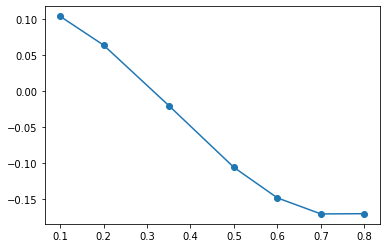

In [25]:
plt.plot(x, res.x, 'o-')

In [26]:
model(res.x)

15.416396762069796

In [27]:
x1 = res.x.copy()
x1[0] = 0.05

model(x1)

-13.284988252607882

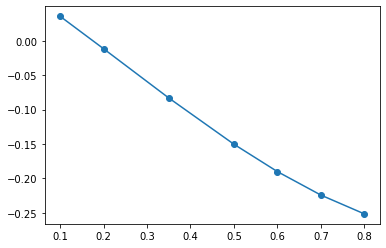

In [28]:
alpha = 1.0
rho = 1.0
sigma = 0.1

K = cov_exp_quad(x, alpha = alpha, rho = rho)
K = K + np.eye(K.shape[0])*1e-6

L_K = np.linalg.cholesky(K)

mu = np.zeros(N)


res = scipy.optimize.minimize(lambda y:-model(y), x0=np.zeros(x.shape[0]))
plt.plot(x, res.x, 'o-')

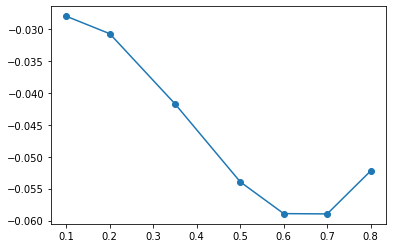

In [29]:
alpha = 1.0
rho = 1.0
sigma = 0.01

K = cov_exp_quad(x, alpha = alpha, rho = rho)
K = K + np.eye(K.shape[0])*1e-6

L_K = np.linalg.cholesky(K)

mu = np.zeros(N)


res = scipy.optimize.minimize(lambda y:-model(y), x0=np.zeros(x.shape[0]))
plt.plot(x, res.x, 'o-')

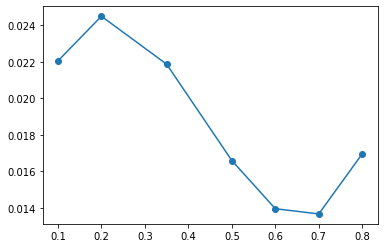

In [30]:
alpha = 1.0
rho = 1.0
sigma = 0.001

K = cov_exp_quad(x, alpha = alpha, rho = rho)
K = K + np.eye(K.shape[0])*1e-6

L_K = np.linalg.cholesky(K)

mu = np.zeros(N)


res = scipy.optimize.minimize(lambda y:-model(y), x0=np.zeros(x.shape[0]))
plt.plot(x, res.x, 'o-')